# 一次训练多个模型

## 测试模型能否跑通

In [ ]:
from data_preprocess import *
from train_and_test import *
from config_loader import *
import os
import time
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

datasets = ['NASA', 'CALCE']
model_names = ['model_v2_2','model_v4_1', 'model_v5']
for dataset in datasets:
    data_config, models_config, start_points, model_save_dir, seeds, data_path, val_bat, test_bat, bats, seq_length, rated_capacity, failure_threshold, device = load_config(dataset)
    for i in range(1):
        seed = seeds[i]
        set_seed(seed)
        for model_name in model_names:
            # 开始时间
            start_time = time.time()

            # 模型保存路径
            model_save_path = f'saved_models/{dataset}/t-{test_bat[-2:]}_s-{i+1}_{model_name}.pth'

            # 参数
            model_config = models_config[model_name]
            batch_size, lr, optim_name, epochs, metric, alpha = (
                model_config['batch_size'],
                model_config['lr'],
                model_config['optimizer'],
                model_config['epochs'],
                model_config['metric'],
                model_config.get('alpha', None)
            )

            # 数据
            batteries_df = read_and_norm(data_path, rated_capacity, failure_threshold)  
            train_df, _, test_df, train_loader, _, test_loader = load_data(batteries_df, test_bat, seq_length, batch_size)

            # 模型、优化器
            model = get_model(model_config, device, seq_length)
            optimizer = get_optimizer(optim_name, model, lr, alpha)
            criterion = nn.MSELoss()

            # 训练
            best_metric = float('inf')
            for epoch in range(5):
                train_loss = train_epoch(model_config, model, train_loader, device, optimizer, criterion)
                test_loss = test_epoch(model_config, model, test_loader, device, criterion)

                # 在训练集上预测, 并计算评价指标(SP=0)
                sp = 0.0
                train_bats = train_df['battery'].unique()
                train_re_list, train_rmse_list, train_mae_list = [], [], []
                for bat in train_bats:
                    bat_df = train_df[train_df['battery'] == bat]
                    train_seq = bat_df['capacity'].to_numpy()
                    train_pred_seq = predict(model_config, model, sp, train_seq, seq_length, failure_threshold, device)
                    train_re, train_rmse, train_mae = cal_metrics(train_seq, train_pred_seq, sp, seq_length, failure_threshold)
                    train_re_list.append(train_re)
                    train_rmse_list.append(train_rmse)
                    train_mae_list.append(train_mae)
                mean_train_re = np.mean(train_re_list)
                mean_train_rmse = np.mean(train_rmse_list)
                mean_train_mae = np.mean(train_mae_list)

                # 在测试集上预测, 并计算评价指标(SP=0)
                test_seq = test_df['capacity'].to_numpy()
                test_pred_seq = predict(model_config, model, sp, test_seq, seq_length, failure_threshold, device)
                test_re, test_rmse, test_mae = cal_metrics(test_seq, test_pred_seq, sp, seq_length, failure_threshold)

                print(
                    f"Dataset: {dataset}, Test bat: {test_bat}, Seed: {i+1}, Model: {model_name}, Epoch [{epoch+1}/{epochs}] | "
                    f"Train Loss: {train_loss:.8f}, Test Loss: {test_loss:.8f} | "
                    f"Train RE: {mean_train_re:.3f}, Test RE: {test_re:.3f}"
                )    

                # 保存模型
                metric = mean_train_re
                if metric < best_metric:
                    best_metric = metric
                    best_model_re, best_model_rmse, best_model_mae = test_re, test_rmse, test_mae
                    print("New best model saved ...")
            
            # 记录实验时间
            end_time = time.time()
            elapsed_time = end_time - start_time 

## 训练代码

In [1]:
from data_preprocess import *
from train_and_test import *
from config_loader import *
import os
import time
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

datasets = ['NASA', 'CALCE']
model_names = ['model_v1', 'model_v2', 'model_v2_1', 'model_v3', 'model_v4']
for dataset in datasets:
    data_config, models_config, start_points, model_save_dir, seeds, data_path, val_bat, _, bats, seq_length, rated_capacity, failure_threshold, device = load_config(dataset)
    for test_bat in bats:
        for i in range(len(seeds)):
            seed = seeds[i]
            set_seed(seed)
            for model_name in model_names:
                # 开始时间
                start_time = time.time()

                # 模型保存路径
                model_save_path = f'saved_models/{dataset}/t-{test_bat[-2:]}_s-{i+1}_{model_name}.pth'

                # 参数
                model_config = models_config[model_name]
                batch_size, lr, optim_name, epochs, metric, alpha = (
                    model_config['batch_size'],
                    model_config['lr'],
                    model_config['optimizer'],
                    model_config['epochs'],
                    model_config['metric'],
                    model_config.get('alpha', None)
                )

                # 数据
                batteries_df = read_and_norm(data_path, rated_capacity, failure_threshold)  
                train_df, _, test_df, train_loader, _, test_loader = load_data(batteries_df, test_bat, seq_length, batch_size)

                # 模型、优化器
                model = get_model(model_config, device, seq_length)
                optimizer = get_optimizer(optim_name, model, lr, alpha)
                criterion = nn.MSELoss()

                # 训练
                best_metric = float('inf')
                for epoch in range(epochs):
                    train_loss = train_epoch(model_config, model, train_loader, device, optimizer, criterion)
                    test_loss = test_epoch(model_config, model, test_loader, device, criterion)

                    # 在训练集上预测, 并计算评价指标(SP=0)
                    sp = 0.0
                    train_bats = train_df['battery'].unique()
                    train_re_list, train_rmse_list, train_mae_list = [], [], []
                    for bat in train_bats:
                        bat_df = train_df[train_df['battery'] == bat]
                        train_seq = bat_df['capacity'].to_numpy()
                        train_pred_seq = predict(model_config, model, sp, train_seq, seq_length, failure_threshold, device)
                        train_re, train_rmse, train_mae = cal_metrics(train_seq, train_pred_seq, sp, seq_length, failure_threshold)
                        train_re_list.append(train_re)
                        train_rmse_list.append(train_rmse)
                        train_mae_list.append(train_mae)
                    mean_train_re = np.mean(train_re_list)
                    mean_train_rmse = np.mean(train_rmse_list)
                    mean_train_mae = np.mean(train_mae_list)

                    # 在测试集上预测, 并计算评价指标(SP=0)
                    test_seq = test_df['capacity'].to_numpy()
                    test_pred_seq = predict(model_config, model, sp, test_seq, seq_length, failure_threshold, device)
                    test_re, test_rmse, test_mae = cal_metrics(test_seq, test_pred_seq, sp, seq_length, failure_threshold)

                    print(
                        f"Dataset: {dataset}, Test bat: {test_bat}, Seed: {i+1}, Model: {model_name}, Epoch [{epoch+1}/{epochs}] | "
                        f"Train Loss: {train_loss:.8f}, Test Loss: {test_loss:.8f} | "
                        f"Train RE: {mean_train_re:.3f}, Test RE: {test_re:.3f}"
                    )    

                    # 保存模型
                    metric = mean_train_re
                    if metric < best_metric:
                        best_metric = metric
                        best_model_re, best_model_rmse, best_model_mae = test_re, test_rmse, test_mae
                        torch.save(model.state_dict(), model_save_path)
                        print("New best model saved ...")
                
                # 记录实验时间
                end_time = time.time()
                elapsed_time = end_time - start_time 

                # 保存单个种子、单个模型的结果
                result = {
                    'dataset': dataset,
                    'test_bat': test_bat,
                    'seed': i + 1,
                    'model': model_name,
                    're': best_model_re,
                    'rmse': best_model_rmse,
                    'mae': best_model_mae,
                    'time': elapsed_time
                }

                pd.DataFrame([result]).to_csv('result/result_temp.csv', mode='a', index=False, header=False)

Dataset: NASA, Test bat: B0005, Seed: 1, Model: model_v1, Epoch [1/100] | Train Loss: 0.10838964, Test Loss: 0.01719464 | Train RE: 0.856, Test RE: 0.864
New best model saved ...
Dataset: NASA, Test bat: B0005, Seed: 1, Model: model_v1, Epoch [2/100] | Train Loss: 0.03194569, Test Loss: 0.01568020 | Train RE: 1.000, Test RE: 1.000
Dataset: NASA, Test bat: B0005, Seed: 1, Model: model_v1, Epoch [3/100] | Train Loss: 0.02215672, Test Loss: 0.00708886 | Train RE: 1.000, Test RE: 1.000
Dataset: NASA, Test bat: B0005, Seed: 1, Model: model_v1, Epoch [4/100] | Train Loss: 0.01552187, Test Loss: 0.00711386 | Train RE: 1.000, Test RE: 1.000
Dataset: NASA, Test bat: B0005, Seed: 1, Model: model_v1, Epoch [5/100] | Train Loss: 0.01371746, Test Loss: 0.00723121 | Train RE: 1.000, Test RE: 1.000
Dataset: NASA, Test bat: B0005, Seed: 1, Model: model_v1, Epoch [6/100] | Train Loss: 0.01374667, Test Loss: 0.00625963 | Train RE: 1.000, Test RE: 1.000
Dataset: NASA, Test bat: B0005, Seed: 1, Model: mod

## 输出结果表格

In [7]:
result_df = pd.read_csv('result/result_temp.csv')
result_df = result_df[result_df['test_bat'].isin(['B0005', 'CS2_35'])]

# 1. 依据 dataset 和 model 分组，计算 mean 和 std
grouped = result_df.groupby(['dataset', 'model']).agg(
    re_mean=('re', 'mean'),
    re_std=('re', 'std'),
    rmse_mean=('rmse', 'mean'),
    rmse_std=('rmse', 'std'),
    mae_mean=('mae', 'mean'),
    mae_std=('mae', 'std')
).reset_index()

# 2. 转换为 mean±std 格式，并保留指定小数位数
grouped['re'] = grouped.apply(lambda x: f"{x['re_mean']:.3f} ± {x['re_std']:.3f}", axis=1)
grouped['rmse'] = grouped.apply(lambda x: f"{x['rmse_mean']:.4f} ± {x['rmse_std']:.4f}", axis=1)
grouped['mae'] = grouped.apply(lambda x: f"{x['mae_mean']:.4f} ± {x['mae_std']:.4f}", axis=1)

# 3. 删除中间计算列
grouped = grouped[['dataset', 'model', 're', 'rmse', 'mae']]

grouped

,dataset,model,re,rmse,mae
0,CALCE,model_v1,0.073 ± 0.045,0.0281 ± 0.0215,0.0227 ± 0.0182
1,CALCE,model_v2,0.110 ± 0.031,0.0264 ± 0.0083,0.0226 ± 0.0078
2,CALCE,model_v2_1,0.090 ± 0.051,0.0271 ± 0.0068,0.0229 ± 0.0068
3,CALCE,model_v2_2,0.080 ± 0.050,0.0263 ± 0.0105,0.0222 ± 0.0098
4,CALCE,model_v3,0.068 ± 0.038,0.0267 ± 0.0165,0.0220 ± 0.0138
5,CALCE,model_v4,0.284 ± 0.410,0.0651 ± 0.0741,0.0457 ± 0.0428
6,CALCE,model_v4_1,0.079 ± 0.024,0.0316 ± 0.0187,0.0258 ± 0.0162
7,CALCE,model_v5,0.092 ± 0.037,0.0224 ± 0.0096,0.0181 ± 0.0090
8,NASA,model_v1,0.208 ± 0.044,0.0519 ± 0.0191,0.0487 ± 0.0180
9,NASA,model_v2,0.222 ± 0.017,0.0591 ± 0.0110,0.0563 ± 0.0097


## 输出指标分布图

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 读取数据并进行排序和筛选
result_df = pd.read_csv('result/result_temp.csv')
result_df = result_df.sort_values(by=['dataset', 'model'])
result_df = result_df[result_df['test_bat'].isin(['B0005', 'CS2_35'])]

# 参数定义
datasets = result_df['dataset'].unique()  # 自动获取数据集列表
metrics = ['re', 'rmse', 'mae']          # 指标名称
labels = ['RE', 'RMSE', 'MAE']           # 指标标签（用于图表标题）

# 设置全局样式
sns.set(style="whitegrid", context="talk")

# 动态调整 ylim 的函数（基于百分位数）
def calculate_ylim_percentile(series, lower_percentile=10, upper_percentile=90, margin=0.1):
    """
    根据数据的百分位数计算 ylim，避免受异常值影响
    - lower_percentile: 下分位点（如 5 表示 5%）
    - upper_percentile: 上分位点（如 95 表示 95%）
    - margin: 额外增加的上下余量（比例）
    """
    lower_bound = series.quantile(lower_percentile / 100)
    upper_bound = series.quantile(upper_percentile / 100)
    range_margin = (upper_bound - lower_bound) * margin
    return lower_bound - range_margin, upper_bound + range_margin

# 循环绘制每个数据集和指标的图表
for dataset in datasets:
    df = result_df[result_df['dataset'] == dataset]
    for metric, label in zip(metrics, labels):
        plt.figure(figsize=(12, 8))
        
        # 动态计算 Y 轴范围（基于 5% 和 95% 分位点）
        ylim = calculate_ylim_percentile(df[metric])
        
        # 使用 seaborn 绘制箱线图
        sns.boxplot(data=df, x="model", y=metric, fliersize=0, palette="Set3")

        # 设置Y轴范围
        plt.ylim(ylim)
        
        # 图表标题和标签
        plt.title(f"{dataset} - Model Performance Distribution ({label})", fontsize=16)
        plt.ylabel(label, fontsize=14)
        plt.xlabel("Model", fontsize=14)
        
        # 调整图例和布局
        plt.xticks(rotation=45, fontsize=12)
        plt.tight_layout()
        plt.show()

## 画预测曲线

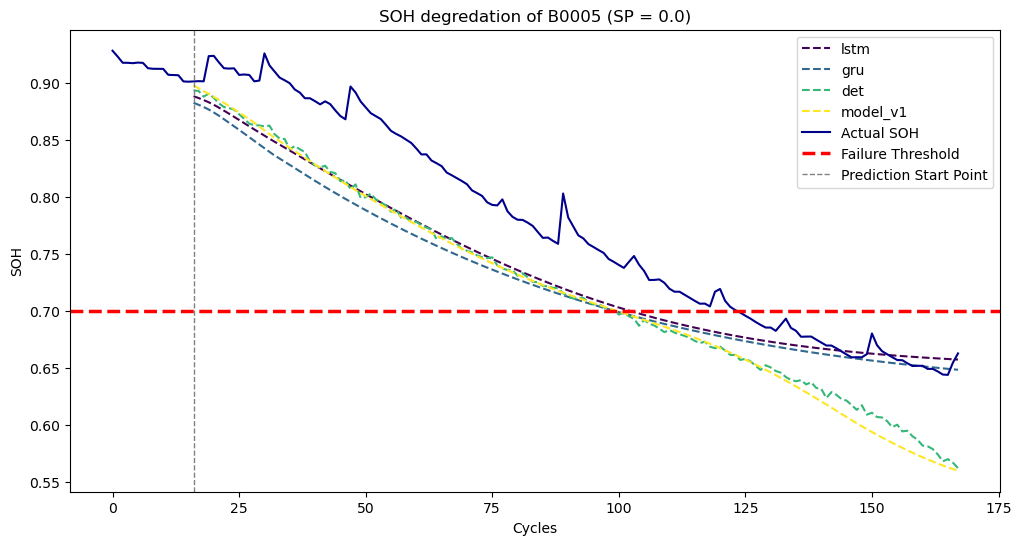

,model,re,rmse,mae
0,lstm,0.168,0.0509,0.0484
1,gru,0.192,0.0601,0.0569
2,det,0.208,0.0526,0.0506
3,model_v1,0.192,0.0531,0.0507


In [6]:
sp = 0.0
pic_save_path = f'pics/{DATASET}/all_models.png'
test_seq = test_df['capacity'].to_numpy()
result = []
pred_seqs = {}

model_names = ['lstm', 'gru', 'det', 'model_v1']
for model_name in model_names:
    model_save_path = f'saved_models/{DATASET}/{model_name}.pth'

    # 加载模型
    model_config = models_config[model_name]
    model = get_model(model_config, device, seq_length)
    model.load_state_dict(torch.load(model_save_path, map_location=device))

    # 预测
    pred_seq = predict(model_config, model, sp, test_seq, seq_length, failure_threshold, device)
    re, rmse, mae = cal_metrics(test_seq, pred_seq, sp, seq_length, failure_threshold)

    result.append({
        'model': model_name,
        're': round(re, 3),
        'rmse': round(rmse, 4),
        'mae': round(mae, 4)
    })
    pred_seqs[model_name] = pred_seq

plt = plot(test_seq, pred_seqs, sp, failure_threshold, seq_length, test_bat)
plt.savefig(pic_save_path)
plt.show()
result_df = pd.DataFrame(result)
result_df